In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from sklearn.linear_model import LinearRegression

import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy import stats
from scipy.signal import periodogram
from datetime import timedelta

In [7]:
adcp1 = xr.open_dataset('ADCP/adcp1.nc')
adcp1_5m = xr.open_dataset('ADCP/adcp1_5m.nc')
adcp1_10m = xr.open_dataset('ADCP/adcp1_10m.nc')
adcp1_10mroll = xr.open_dataset('ADCP/adcp1_10mroll.nc')

adcp2 = xr.open_dataset('ADCP/adcp2.nc')
adcp2_1m = xr.open_dataset('ADCP/adcp2_1m.nc')
adcp2_5m = xr.open_dataset('ADCP/adcp2_5m.nc')
adcp2_10m = xr.open_dataset('ADCP/adcp2_10m.nc')
adcp2_10mroll = xr.open_dataset('ADCP/adcp2_10mroll.nc')

temp = xr.open_dataset('Temperature/temp_w_rho.nc')

### Richardson number Ri
- Ri = N^2 / (du/dz)^2
- N^2 = -(g/rho) * (drho/dz)

ADCP pressure sensor is .396m above ground
ADCP fibergrate platform adds extra .0254m (1 inch)
ADCP blanking distance is .81m from transducer head

ADCP records first depth cell at 1.2314m above the bottom (~ 1.25m)

Total depth (H) is at ~10.7m (35 feet)

Depth of first cell is about 9.45m

In [16]:
adcp1

<xarray.Dataset>
Dimensions:         (BinDist: 47, bin: 47, time: 34834)
Coordinates:
    BinDist         (bin) float64 0.81 1.06 1.31 1.56 ... 11.81 12.06 12.31
  * time            (time) datetime64[ns] 2022-07-21T10:30:00 ... 2022-08-14T...
Dimensions without coordinates: bin
Data variables:
    Pitch           (time) float64 25.4 25.4 25.39 25.4 ... -26.51 -26.51 -26.51
    Roll            (time) float64 26.22 26.22 26.22 26.22 ... 25.22 25.21 25.22
    Heading         (time) float64 193.2 193.2 193.3 193.2 ... 3.17 3.96 4.0
    Temperature     (time) float64 22.17 22.17 22.17 22.17 ... 25.16 25.12 25.09
    Depth           (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Battery         (time) int64 180 180 180 180 180 181 ... 142 142 142 141 142
    East            (BinDist, time) float64 ...
    North           (BinDist, time) float64 ...
    Vertical        (BinDist, time) float64 ...
    Magnitude       (BinDist, time) float64 ...
    Direction       (BinDist, time) float64 ...
    Error_velocity  (BinDist, time) float64 ...
    Correlation     (BinDist, time) int64 ...
    PG1             (BinDist, time) int64 ...
    PG4             (BinDist, time) int64 ...
    EA1             (BinDist, time) int64 ...
    EA2             (BinDist, time) int64 ...
    EA3             (BinDist, time) int64 ...
    EA4             (BinDist, time) int64 ...
    Flag            (BinDist, time) float64 ...
Attributes:
    description:          Velocity in beam coordinates
    PingsPerEns:          70
    TimePerPing:          00:00.85
    First Ensemble Date:  22/07/21
    First Ensemble Time:  10:30:00.00
    Ensemble Interval:    60.0
    1st Bin Range:        0.81
    Bin Size:             0.25
    RDI binary file:      C:\Users\tconnolly\Desktop\LG_SWC_Depl\ADCP\SWC0100...
    Instrument:           Broadband 1228.8 kHz

In [23]:
adcp1['BinDist'] = -(adcp1.BinDist - (.81 + 9.45))
adcp1

<xarray.Dataset>
Dimensions:         (BinDist: 47, bin: 47, time: 34834)
Coordinates:
    BinDist         (bin) float64 9.45 9.2 8.95 8.7 ... -1.3 -1.55 -1.8 -2.05
  * time            (time) datetime64[ns] 2022-07-21T10:30:00 ... 2022-08-14T...
Dimensions without coordinates: bin
Data variables:
    Pitch           (time) float64 25.4 25.4 25.39 25.4 ... -26.51 -26.51 -26.51
    Roll            (time) float64 26.22 26.22 26.22 26.22 ... 25.22 25.21 25.22
    Heading         (time) float64 193.2 193.2 193.3 193.2 ... 3.17 3.96 4.0
    Temperature     (time) float64 22.17 22.17 22.17 22.17 ... 25.16 25.12 25.09
    Depth           (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Battery         (time) int64 180 180 180 180 180 181 ... 142 142 142 141 142
    East            (BinDist, time) float64 ...
    North           (BinDist, time) float64 ...
    Vertical        (BinDist, time) float64 ...
    Magnitude       (BinDist, time) float64 ...
    Direction       (BinDist, time) float64 ...
    Error_velocity  (BinDist, time) float64 ...
    Correlation     (BinDist, time) int64 ...
    PG1             (BinDist, time) int64 ...
    PG4             (BinDist, time) int64 ...
    EA1             (BinDist, time) int64 ...
    EA2             (BinDist, time) int64 ...
    EA3             (BinDist, time) int64 ...
    EA4             (BinDist, time) int64 ...
    Flag            (BinDist, time) float64 ...
Attributes:
    description:          Velocity in beam coordinates
    PingsPerEns:          70
    TimePerPing:          00:00.85
    First Ensemble Date:  22/07/21
    First Ensemble Time:  10:30:00.00
    Ensemble Interval:    60.0
    1st Bin Range:        0.81
    Bin Size:             0.25
    RDI binary file:      C:\Users\tconnolly\Desktop\LG_SWC_Depl\ADCP\SWC0100...
    Instrument:           Broadband 1228.8 kHz

In [4]:
temp

<xarray.Dataset>
Dimensions:      (depth: 7, time: 69761)
Coordinates:
    dcell        (depth) float64 ...
  * time         (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T10:...
Dimensions without coordinates: depth
Data variables:
    Temperature  (depth, time) float64 ...
    Rho          (depth, time) float64 ...
Attributes:
    description:  Temperature of water column over time

In [33]:
# Slice data so the timelines are the same
adcp1_d1 = adcp1.sel(time = slice('2022-07-21T22:39:00.000000000', '2022-08-14T15:03:00.000000000'))
temp_d1 = temp.sel(time = slice('2022-07-21T22:39:00.000000000', '2022-08-14T15:03:00.000000000'))

In [39]:
test = np.arange(2.2, 9.7, .25)

In [50]:
test

array([2.2 , 2.45, 2.7 , 2.95, 3.2 , 3.45, 3.7 , 3.95, 4.2 , 4.45, 4.7 ,
       4.95, 5.2 , 5.45, 5.7 , 5.95, 6.2 , 6.45, 6.7 , 6.95, 7.2 , 7.45,
       7.7 , 7.95, 8.2 , 8.45, 8.7 , 8.95, 9.2 , 9.45])

In [54]:
temp_d1.dcell.interp(depth = [2, 2.25, 2.5, 2.75, 3])

<xarray.DataArray 'dcell' (depth: 5)>
array([6. , 6.5, 7. , 7.5, 8. ])
Coordinates:
    dcell    (depth) float64 6.0 6.5 7.0 7.5 8.0
  * depth    (depth) float64 2.0 2.25 2.5 2.75 3.0

In [55]:
temp_d1.dcell

<xarray.DataArray 'dcell' (depth: 7)>
array([2. , 4. , 6. , 8. , 9.1, 9.4, 9.7])
Coordinates:
    dcell    (depth) float64 2.0 4.0 6.0 8.0 9.1 9.4 9.7
Dimensions without coordinates: depth

In [53]:
# Interpolate density over adcp bins
temp_d1.dcell.interp(depth = test, method="quadratic", kwargs={"fill_value": "extrapolate"})

<xarray.DataArray 'dcell' (depth: 30)>
array([ 6.41684777,  6.94827281,  7.46594323,  7.91773623,  8.30207233,
        8.61895153,  8.87179184,  9.06764287,  9.20671825,  9.28901798,
        9.33530572,  9.38840654,  9.44961817,  9.5189406 ,  9.59637384,
        9.68191789,  9.77557275,  9.87733841,  9.98721489, 10.10520217,
       10.23130025, 10.36550915, 10.50782885, 10.65825936, 10.81680067,
       10.9834528 , 11.15821573, 11.34108947, 11.53207401, 11.73116937])
Coordinates:
    dcell    (depth) float64 6.417 6.948 7.466 7.918 ... 11.16 11.34 11.53 11.73
  * depth    (depth) float64 2.2 2.45 2.7 2.95 3.2 ... 8.45 8.7 8.95 9.2 9.45

<ipython-input-11-ad662d3b7a7b>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temp_d1.time, temp_d1.dcell, temp_d1.Rho ,norm=norm)


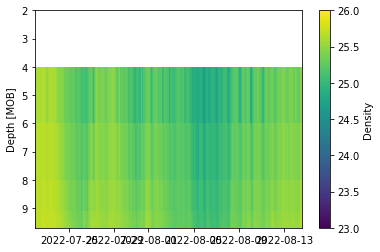

In [11]:
# Current profile
plt.figure()
minvel = 23 # Limits for the colorbars used on the adcp colorplots
maxvel = 26
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)
#plt.title('ADCP Eastern Velocity')
plt.pcolormesh(temp_d1.time, temp_d1.dcell, temp_d1.Rho ,norm=norm)
plt.colorbar(label='Density')
#plt.gca().invert_yaxis()
plt.ylabel('Depth [MOB]')
plt.margins(x=.01)

In [3]:
da = xr.DataArray(
    data=[[1, 4, 2, 9], [2, 7, 6, np.nan], [6, np.nan, 5, 8]],
    dims=("x", "y"),
    coords={"x": [0, 1, 2], "y": [10, 12, 14, 16]},
)

In [5]:
da

<xarray.DataArray (x: 3, y: 4)>
array([[ 1.,  4.,  2.,  9.],
       [ 2.,  7.,  6., nan],
       [ 6., nan,  5.,  8.]])
Coordinates:
  * x        (x) int32 0 1 2
  * y        (y) int32 10 12 14 16

In [42]:
interp = da.interp(x=[0, 0.75, 1.25, 1.75])

In [44]:
interp.x

<xarray.DataArray 'x' (x: 4)>
array([0.  , 0.75, 1.25, 1.75])
Coordinates:
  * x        (x) float64 0.0 0.75 1.25 1.75

In [24]:
da.interp(x=[1.75, 1.25, 0.75, 0])

<xarray.DataArray (x: 4, y: 4)>
array([[5.  ,  nan, 5.25,  nan],
       [3.  ,  nan, 5.75,  nan],
       [1.75, 6.25, 5.  ,  nan],
       [1.  , 4.  , 2.  ,  nan]])
Coordinates:
  * y        (y) int32 10 12 14 16
  * x        (x) float64 1.75 1.25 0.75 0.0

<xarray.DataArray 'BinDist' (bin: 30)>
array([9.45, 9.2 , 8.95, 8.7 , 8.45, 8.2 , 7.95, 7.7 , 7.45, 7.2 , 6.95,
       6.7 , 6.45, 6.2 , 5.95, 5.7 , 5.45, 5.2 , 4.95, 4.7 , 4.45, 4.2 ,
       3.95, 3.7 , 3.45, 3.2 , 2.95, 2.7 , 2.45, 2.2 ])
Coordinates:
    BinDist  (bin) float64 9.45 9.2 8.95 8.7 8.45 8.2 ... 3.2 2.95 2.7 2.45 2.2
Dimensions without coordinates: bin

In [31]:
temp

<xarray.Dataset>
Dimensions:      (depth: 7, time: 69761)
Coordinates:
    dcell        (depth) float64 ...
  * time         (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T10:...
Dimensions without coordinates: depth
Data variables:
    Temperature  (depth, time) float64 ...
    Rho          (depth, time) float64 ...
Attributes:
    description:  Temperature of water column over time

In [ ]:
# Interpolate density over adcp bins
temp_d1.interp(depth = np.array(adcp1.BinDist),method="linear", kwargs={"fill_value": "extrapolate"})

### Richardson number from ADV data

In [56]:
adv1 = xr.open_dataset('ADV/adv1_1m.nc')

In [57]:
adv1

<xarray.Dataset>
Dimensions:         (time: 13460)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-02T09:40:00 ... 2022-08-11T...
Data variables:
    Burst_number    (time) float64 ...
    East            (time) float64 ...
    North           (time) float64 ...
    Vertical        (time) float64 ...
    CSPD            (time) float64 ...
    CDIR            (time) float64 ...
    SNR_B1          (time) float64 ...
    SNR_B2          (time) float64 ...
    SNR_B3          (time) float64 ...
    Correlation_B1  (time) float64 ...
    Correlation_B2  (time) float64 ...
    Correlation_B3  (time) float64 ...
    Pressure        (time) float64 ...
    Checksum        (time) float64 ...
    Dat_flag        (time) float64 ...